In [1]:
import os
import numpy as np
import pandas as pd
import sys
import sklearn

#import scipy.io as io
import os.path
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [2]:
np.random.seed(10)

base_dir = os.path.dirname(os.path.realpath('__file__'))
archive_name = 'UCRArchive_2018'
datasets_dict = {}

In [3]:
def read_dataset(dataset_name):
    root_dir_dataset = base_dir + '/' + archive_name + '/' + dataset_name
    
    df_train = pd.read_csv(root_dir_dataset + '/' + dataset_name + '_TRAIN.tsv', sep='\t', header=None)
    
    df_test = pd.read_csv(root_dir_dataset + '/' + dataset_name + '_TEST.tsv', sep='\t', header=None)
    
    y_train = df_train.values[:, 0]
    y_test = df_test.values[:, 0]
    
    x_train = df_train.drop(columns=[0])
    x_test = df_test.drop(columns=[0])
    
    x_train.columns = range(x_train.shape[1])
    x_test.columns = range(x_test.shape[1])
    
    x_train = x_train.values
    x_test = x_test.values
    
    
    labels = np.hstack((y_train, y_test)).astype(int)
    _, labels = np.unique(labels, return_inverse=True)
    features = np.vstack((x_train, x_test))
    
    
    n_ = features.shape[0]
    shuffle_id = np.random.permutation(np.arange(n_))
    Dataset = features[shuffle_id]
    label = labels[shuffle_id]
    
    training_set = Dataset[:int(n_*0.7)]
    test_set = Dataset[int(n_*0.7):]
    train_label = label[:int(n_*0.7)]
    test_label = label[int(n_*0.7):]
    
    datasets_dict[dataset_name] = (training_set, train_label, test_set, test_label)
    return Dataset,label

In [4]:
#dataset_name = 'Wafer'
dataset_name = 'ItalyPowerDemand'
#dataset_name = 'FreezerRegularTrain'
Dataset,label = read_dataset(dataset_name)
training_set, training_label, test_set, test_label = datasets_dict[dataset_name]

In [5]:
training_set.shape

(767, 24)

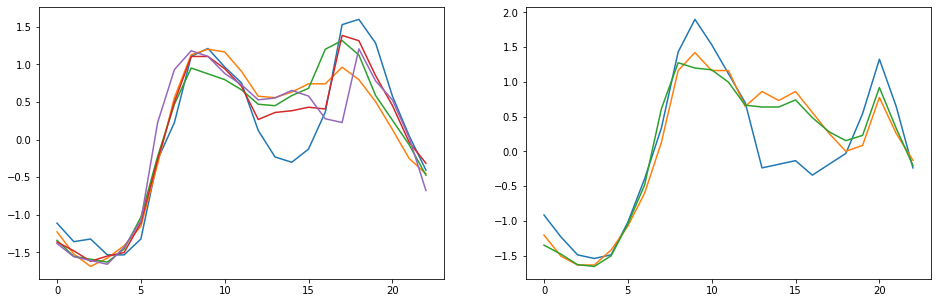

In [6]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
for i in range(5):
    plt.plot(training_set[training_label==0][i,1:])
plt.subplot(1,2,2)    
for i in range(3):
    plt.plot(training_set[training_label==1][i,1:])

In [7]:
def encoder_block0(
    fileter_size,
    kernel_size,
    stride_size,
    input_layer,
    name=None
):
    cnn_output = layers.Conv1D(
        filters=fileter_size,
        kernel_size=kernel_size,
        strides=stride_size,
        padding="same",
        activation="relu",
        name=f'conv_{name}'
    )(input_layer)
    return cnn_output

In [8]:
cnn_name_list = ['block1','block2','block3','block4','encoder_l5','encoder_l6','encoded',
                'decoder_l6','decoder_l5','decoder_l4','decoder_l3','decoder_l2','decoder_l1','decoder_l0']

if dataset_name == 'Wafer':
    input_sig0 = keras.Input(shape=(24,1),name="input_signal0")

    f0 = input_sig0.shape[2]
    f1,k1,s1 = 32,10,2
    l1 = input_sig0.shape[1]//2
    f2,k2,s2 = 32,5,2
    l2 = l1//2
    f3,k3,s3 = 32,3,2
    l3 = l2//2
    f4,k4,s4 = 16,3,1
    l4 = l3//1
elif dataset_name == 'ItalyPowerDemand':
    input_sig0 = keras.Input(shape=(24,1),name="input_signal0")

    f0 = input_sig0.shape[2]
    f1,k1,s1 = 32,5,2
    l1 = input_sig0.shape[1]//2
    f2,k2,s2 = 32,5,1
    l2 = l1//1
    f3,k3,s3 = 32,3,1
    l3 = l2//1
    f4,k4,s4 = 16,3,1
    l4 = l3//1
elif dataset_name == 'FreezerRegularTrain':
    
    input_sig0 = keras.Input(shape=(301,1),name="input_signal0")
    f0 = input_sig0.shape[2]
    f1,k1,s1 = 16,20,2
    l1 = input_sig0.shape[1]//2
    f2,k2,s2 = 16,10,2
    l2 = l1//2
    f3,k3,s3 = 16,5,2
    l3 = l2//2
    f4,k4,s4 = 8,3,2
    l4 = l3//2+1
    
encoded01 = encoder_block0(f1,k1,s1,input_sig0,cnn_name_list[0]+'0')
encoded02= encoder_block0(f2,k2,s2,encoded01,cnn_name_list[1]+'0')
encoded03 = encoder_block0(f3,k3,s3,encoded02,cnn_name_list[2]+'0')
encoded04 = encoder_block0(f4,k4,s4,encoded03,cnn_name_list[3]+'0')
encoded04 = layers.Flatten()(encoded04)
encoded05 = layers.Dense(100,activation="relu",name=cnn_name_list[4]+'0')(encoded04)#200 for Wafer
encoded06 = layers.Dense(50,activation="relu",name=cnn_name_list[5]+'0')(encoded05)
encoded0 = layers.Dense(3,name=cnn_name_list[6]+'0')(encoded06)
decoder06 = layers.Dense(50,activation="relu",name=cnn_name_list[7]+'0')(encoded0)
decoder05 = layers.Dense(100,activation="relu",name=cnn_name_list[8]+'0')(decoder06)
decoder04 = layers.Dense(l4*f4,activation="relu",name=cnn_name_list[9]+'0')(decoder05)
decoder04 = layers.Reshape((l4,f4))(decoder04)
decoder03 = layers.Conv1DTranspose(filters=f4, kernel_size=k4, strides=s4, activation="relu",padding="same",name=cnn_name_list[10]+'0')(decoder04)
decoder02 = layers.Conv1DTranspose(filters=f3, kernel_size=k3, strides=s3, activation="relu",padding="same",name=cnn_name_list[11]+'0')(decoder03)
decoder01 = layers.Conv1DTranspose(filters=f2, kernel_size=k2, strides=s2, activation="relu",padding="same",name=cnn_name_list[12]+'0')(decoder02)#,output_padding=1 for Wafer
decoded0 = layers.Conv1DTranspose(filters=f0, kernel_size=k1, strides=s1,padding="same",name=cnn_name_list[13]+'0')(decoder01)

In [9]:
model0 = keras.Model(input_sig0, decoded0, name="test0")
model0.summary()

Model: "test0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_signal0 (InputLayer)   [(None, 24, 1)]           0         
_________________________________________________________________
conv_block10 (Conv1D)        (None, 12, 32)            192       
_________________________________________________________________
conv_block20 (Conv1D)        (None, 12, 32)            5152      
_________________________________________________________________
conv_block30 (Conv1D)        (None, 12, 32)            3104      
_________________________________________________________________
conv_block40 (Conv1D)        (None, 12, 16)            1552      
_________________________________________________________________
flatten (Flatten)            (None, 192)               0         
_________________________________________________________________
encoder_l50 (Dense)          (None, 100)               19300 

In [10]:
reconstruction_loss0 = keras.losses.mse(input_sig0, decoded0)
reconstruction_loss0 = tf.reduce_mean(tf.reduce_sum(reconstruction_loss0))
model0.add_loss(reconstruction_loss0)

In [11]:
tf.random.set_seed(1)

model0.compile(optimizer=keras.optimizers.Adam(),)

model0.fit(
    training_set,
    training_set,
    epochs=500,
    batch_size=32,
)

In [12]:
#model0.save('./models/my_model0_'+dataset_name+'.h5')
#model0 = keras.models.load_model('./models/my_model0_'+dataset_name+'.h5')
model0.load_weights('./models/my_model0_'+dataset_name+'.h5')
K.clear_session()

In [13]:
Pred_sig = model0.predict(test_set[0:10])

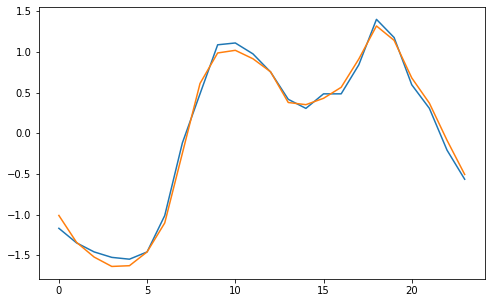

In [14]:
i=5
plt.figure(figsize=(8,5))
plt.plot(test_set[i,:])
plt.plot(Pred_sig[i,:])

In [15]:
encoded0 = keras.Model(inputs=model0.input,
                       outputs=model0.get_layer('encoded0').output)

encoded_0 = []
for k in range(test_set.shape[0]//10):
    encoded_0.append(encoded0(test_set[k*10:k*10+10]).numpy())
encoded_0 = np.concatenate(encoded_0,axis = 0)

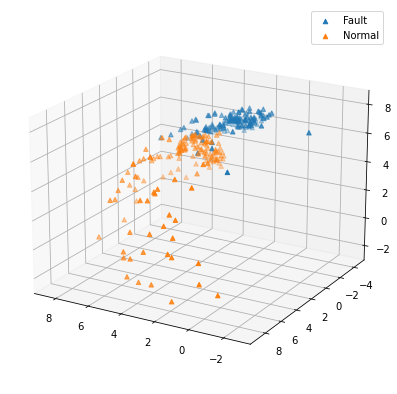

In [298]:
normal_index = test_label[:encoded_0.shape[0]]==0
fault_index1 = test_label[:encoded_0.shape[0]]==1
n_plot = 1000

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    encoded_0[normal_index,0],
    encoded_0[normal_index,1],
    encoded_0[normal_index,2],
    marker='^'
)
ax.scatter(
    encoded_0[0:n_plot][fault_index1[0:n_plot],0],
    encoded_0[0:n_plot][fault_index1[0:n_plot],1],
    encoded_0[0:n_plot][fault_index1[0:n_plot],2],
    marker='^'
)


plt.legend(['Fault','Normal'])
ax.azim = 120
ax.elev = 20

In [16]:
def attention_calculate(input_layer,fileter_size,name,res=False):
    
    _,layer_len,layer_width = input_layer.shape
    token_time = 8

    token = input_layer[:,0:layer_len-token_time,:]
    for i in range(token_time-1):
        token = layers.Concatenate(axis=-1)([token,input_layer[:,1+i:layer_len-token_time+1+i,:]])
    token = layers.ZeroPadding1D(padding=int(token_time/2))(token)
    
    if fileter_size// 8 <2:
        f_s =fileter_size
    else: 
        f_s = fileter_size//4
       
    attention_k = layers.Conv1D(filters=f_s,kernel_size=5,strides=1,padding="same",activation="relu",name=f'{name}_key1')(token)
    #attention_k = layers.Conv1D(filters=fileter_size,kernel_size=5,strides=1,padding="same",activation="relu",name=f'{name}_key2')(attention_k)
    attention_k = layers.Conv1D(filters=fileter_size,kernel_size=3,strides=1,padding="same",name=f'{name}_key3')(attention_k)

    attention_q = layers.Conv1D(filters=f_s,kernel_size=5,strides=1,padding="same",activation="relu",name=f'{name}_query1')(token)
    #attention_q = layers.Conv1D(filters=fileter_size,kernel_size=5,strides=1,padding="same",activation="relu",name=f'{name}_query2')(attention_q)
    attention_q = layers.Conv1D(filters=fileter_size,kernel_size=3,strides=1,padding="same",name=f'{name}_query3')(attention_q)

    attention_v = layers.Conv1D(filters=f_s,kernel_size=5,strides=1,padding="same",activation="relu",name=f'{name}_value1')(token)
    #attention_v = layers.Conv1D(filters=fileter_size,kernel_size=5,strides=1,padding="same",activation="relu",name=f'{name}_value2')(attention_v)
    attention_v = layers.Conv1D(filters=fileter_size,kernel_size=3,strides=1,padding="same",name=f'{name}_value3')(attention_v)
    
    attention_v = layers.Permute((2,1))(attention_v)
        
    attention_kq = layers.Dot(axes=2)([attention_q,attention_k])
    
    if res:
        attention_kq = layers.Lambda(lambda x: x)(attention_kq)
    
    attention_kq =  layers.Activation('relu', name=f'{name}_kq')(attention_kq)
    attention_kq = layers.BatchNormalization(name=f'{name}_normalization')(attention_kq)
 
    attention_score = layers.Dot(axes=2)([attention_kq,attention_v])
    attention_score = layers.Activation('sigmoid', name=f'{name}_score')(attention_score)

    return attention_score,attention_kq

In [17]:
def encoder_block(
    fileter_size,
    fileter_size0,
    kernel_size,
    stride_size,
    input_layer,
    name=None,
    res=False,
):
    head_num = 3
    attention_score_list = []
    attention_kq_list = []
    
    for i in range(head_num):
        score,kq = attention_calculate(input_layer,fileter_size0,name=f'{name}_attention'+str(i),res=res)
        attention_score_list.append(score)
        attention_kq_list.append(kq)
    if res:
        attention_score = layers.Average()(attention_score_list)
        #attention_score = layers.Lambda(lambda x: 0.5+K.sign(x-K.tile(K.reshape(K.mean(x,axis=1),[-1,1,x.shape[2]]),[1,x.shape[1],1]))/2,name=f'attention_score{name}')(attention_score)
        attention_score = layers.Lambda(lambda x: 1-x,name=f'attention_score{name}')(attention_score)
    else:
        attention_score = layers.Average(name=f'attention_score{name}')(attention_score_list)
        
    attention_kq =  layers.Average(name=f'attention_kq_{name}')(attention_kq_list)
    
    input_att = layers.multiply([attention_score,input_layer])
    output_layer = layers.Conv1D(
        filters=fileter_size,
        kernel_size=kernel_size,
        strides=stride_size,
        padding="same",
        activation="relu",
        name=f'conv_{name}'
    )(input_att)
    #output_layer = tf.keras.layers.MaxPooling1D(
    #    pool_size=2,
    #    strides=2
    #)(output_layer)
    return output_layer,attention_score,attention_kq

In [18]:
def Model_construct(input_sig,cnn_name_list):
    

    f1,k1,s1 = 32,5,2
    l1 = input_sig0.shape[1]//2
    f2,k2,s2 = 32,5,1
    l2 = l1//1
    f3,k3,s3 = 32,3,1
    l3 = l2//1
    f4,k4,s4 = 16,3,1
    l4 = l3//1

    if 'res' in cnn_name_list[0]:
        res=True
    else:
        res=False

    encoded1,attention1,kq1 = encoder_block(f1,f0,k1,s1,input_sig,cnn_name_list[0],res)
    encoded2,attention2,kq2 = encoder_block(f2,f1,k2,s2,encoded1,cnn_name_list[1],res)
    encoded3,attention3,kq3 = encoder_block(f3,f2,k3,s3,encoded2,cnn_name_list[2],res)
    encoded4,attention4,kq4 = encoder_block(f4,f3,k4,s4,encoded3,cnn_name_list[3],res)
    encoded4 = layers.Flatten()(encoded4)
    encoded5 = layers.Dense(100,activation="relu",name=cnn_name_list[4])(encoded4)
    encoded6 = layers.Dense(50,activation="relu",name=cnn_name_list[5])(encoded5)
    encoded = layers.Dense(3,name=cnn_name_list[6])(encoded6)
    decoder6 = layers.Dense(50,activation="relu",name=cnn_name_list[7])(encoded)
    decoder5 = layers.Dense(100,activation="relu",name=cnn_name_list[8])(decoder6)
    decoder4 = layers.Dense(l4*f4,activation="relu",name=cnn_name_list[9])(decoder5)
    decoder4 = layers.Reshape((l4,f4))(decoder4)
    decoder3 = layers.Conv1DTranspose(filters=f4, kernel_size=k4, strides=s4, activation="relu",padding="same",name=cnn_name_list[10])(decoder4)
    decoder2 = layers.Conv1DTranspose(filters=f3, kernel_size=k3, strides=s3, activation="relu",padding="same",name=cnn_name_list[11])(decoder3)
    decoder1 = layers.Conv1DTranspose(filters=f2, kernel_size=k2, strides=s2, activation="relu",padding="same",name=cnn_name_list[12])(decoder2)
    decoded = layers.Conv1DTranspose(filters=f0, kernel_size=k1, strides=s1,padding="same",name=cnn_name_list[13])(decoder1)
    attention = [attention1,attention2,attention3,attention4]
    kq = [kq1,kq2,kq3,kq4]
    
    return decoded,attention,kq,encoded

In [19]:
input_sig = keras.Input(shape=(24,1),name="input_signal")
decoded,attention,kq,encoded = Model_construct(input_sig,cnn_name_list)

attention1,attention2,attention3,attention4 = attention
kq1,kq2,kq3,kq4 = kq

model = keras.Model(input_sig, decoded, name="test")

In [20]:
def trans_weight(model1,model):
    for i in model1.layers:
        if i.trainable == True and i.get_weights()!=[]:
            model.get_layer(i.name).set_weights(model1.get_layer(i.name).get_weights())
            print(i.name)

load_model = 1
if load_model==1:
    #model1 = keras.models.load_model('./models/my_model_'+dataset_name+'.h5')
    #trans_weight(model1,model)
    model.load_weights('./models/my_model_'+dataset_name+'.h5')

#model = keras.models.load_model('./models/my_model_'+dataset_name+'.h5')

In [21]:
def set_transfered_model(layer1,layer01):
    model.get_layer(layer1).set_weights(model0.get_layer(layer01).get_weights())
    model.get_layer(layer1).trainable = True
    
for layer_name in cnn_name_list:
    if 'block' in layer_name:
        layer_name = 'conv_'+layer_name
    set_transfered_model(layer_name,layer_name+'0')

In [22]:
eps = 1e-10
reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.mse(input_sig, decoded)))

reg_loss1 =tf.reduce_mean(tf.reduce_sum(K.abs(attention1)))+ tf.reduce_mean(tf.reduce_sum(K.abs(attention2)))+tf.reduce_mean(tf.reduce_sum(K.abs(attention3)))+tf.reduce_mean(tf.reduce_sum(K.abs(attention4)))
reg_loss2 =tf.reduce_mean(tf.reduce_sum(K.square(attention1)))+ tf.reduce_mean(tf.reduce_sum(K.square(attention2)))+tf.reduce_mean(tf.reduce_sum(K.square(attention3)))+tf.reduce_mean(tf.reduce_sum(K.square(attention4)))
#reg_loss5 =tf.reduce_sum(tf.reduce_sum(K.abs(attention1)))+ tf.reduce_mean(tf.reduce_sum(K.abs(attention2)))+tf.reduce_mean(tf.reduce_sum(K.abs(attention3)))+tf.reduce_mean(tf.reduce_sum(K.abs(attention4)))
reg_loss3 =tf.reduce_mean(tf.reduce_sum(-K.abs(attention1)*K.log(K.abs(attention1+eps))))+ \
tf.reduce_mean(tf.reduce_sum(-K.abs(attention2)*K.log(K.abs(attention2+eps))))+\
tf.reduce_mean(tf.reduce_sum(-K.abs(attention3)*K.log(K.abs(attention3+eps))))+\
tf.reduce_mean(tf.reduce_sum(-K.abs(attention4)*K.log(K.abs(attention4+eps))))

total_loss = reconstruction_loss+1e-5*reg_loss3#+1e-4*reg_loss1#+1/reg_loss2
model.add_loss(total_loss)

In [23]:
model.compile(optimizer=keras.optimizers.Adam(),)

model.fit(
    training_set,
    training_set,
    epochs=50,
    batch_size=32
)

In [29]:
#model.save('./models/my_model_'+dataset_name+'.h5')
#model = keras.models.load_model('./models/my_model_'+dataset_name+'.h5')
model.load_weights('./models/my_model_'+dataset_name+'.h5')
K.clear_session()

In [30]:
Pred_sig = model.predict(test_set[0:10])

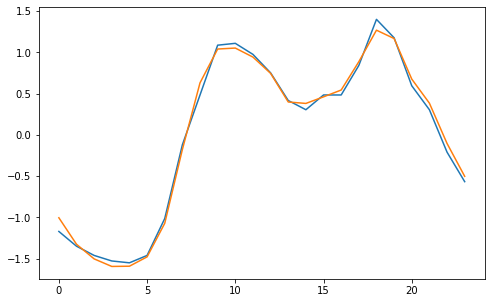

In [31]:
i=5
plt.figure(figsize=(8,5))
plt.plot(test_set[i,:])
plt.plot(Pred_sig[i,:])

In [32]:
i=10
head_num = 3
att1_kq = []
for k in range(head_num):
    attention1_kq = keras.Model(inputs=model.input,
                                outputs=model.get_layer('block1_attention'+str(k)+'_kq').output)
    att1_kq.append(attention1_kq(training_set[i:i+1]).numpy()[0])
attention1_kq_value = np.mean(att1_kq,axis=0)

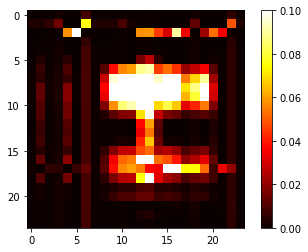

In [33]:
plt.imshow(attention1_kq_value, cmap=plt.cm.hot,vmin=0, vmax=0.1) #,vmin=0, vmax=1
plt.colorbar()
plt.show()

Text(0.5, 1.0, 'attention score')

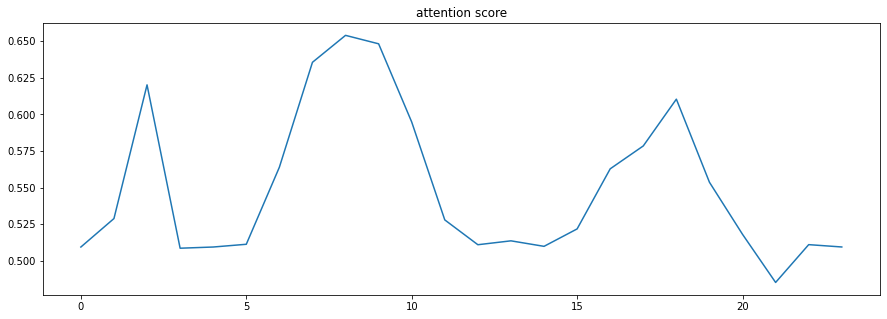

In [34]:
i=7
attention_score_block1 = keras.Model(inputs=model.input,
                                     outputs=model.get_layer('attention_scoreblock1').output)
attention_score1 = attention_score_block1(training_set[i:i+1])
plt.figure(figsize=(15,5))
plt.plot(attention_score1[0,:])
plt.title('attention score')

In [36]:
encoded_att = keras.Model(inputs=model.input,
                          outputs=model.get_layer('encoded').output)

encoded_c = []
for k in range(test_set.shape[0]//10):
    encoded_c.append(encoded_att(test_set[k*10:k*10+10]).numpy())
encoded_c = np.concatenate(encoded_c,axis = 0)

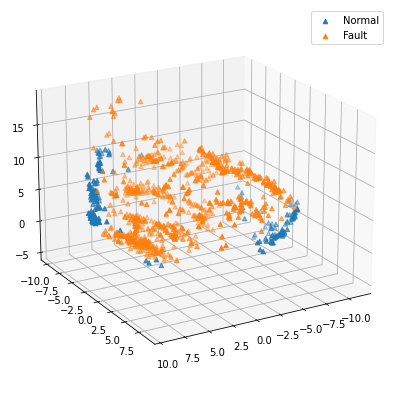

In [224]:
normal_index = test_label[:encoded_0.shape[0]]==0
fault_index1 = test_label[:encoded_0.shape[0]]==1
n_plot = 1000

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    encoded_c[normal_index,0],
    encoded_c[normal_index,1],
    encoded_c[normal_index,2],
    marker='^'
)
ax.scatter(
    encoded_c[0:n_plot][fault_index1[0:n_plot],0],
    encoded_c[0:n_plot][fault_index1[0:n_plot],1],
    encoded_c[0:n_plot][fault_index1[0:n_plot],2],
    marker='^'
)

plt.legend(['Normal','Fault'])
ax.azim = 60
ax.elev = 20

In [789]:
#model.load_weights('./Models/my_model_Wafer.h5')
#model.trainable=False

In [37]:
cnn_name_list_res = []
for name in cnn_name_list:
    cnn_name_list_res.append(name+"_res")

input_sig_res = keras.Input(shape=(24,1),name="input_signal_res")
decoded_res,_,_,_ = Model_construct(input_sig_res,cnn_name_list_res)

model_res = keras.Model(input_sig_res,decoded_res, name="test_res")


In [38]:
def set_transfered_model_res1(layer1,layer01):
    model_res.get_layer(layer1).set_weights(model0.get_layer(layer01).get_weights())
    model_res.get_layer(layer1).trainable = False
    
for layer_name in cnn_name_list:
    if 'block' in layer_name:
        layer_name = 'conv_'+layer_name
    set_transfered_model_res1(layer_name+'_res',layer_name+'0')

In [39]:
def set_transfered_model_res2(layer1_res,layer1):
    model_res.get_layer(layer1_res).set_weights(model.get_layer(layer1).get_weights())
    model_res.get_layer(layer1_res).trainable = True


att_method = "convolution"
if att_method=="dense":
    attention_name_list = ['_key1','_key2','_query1','_query2','_value1','_value2']
elif att_method=="convolution":
    #attention_name_list = ['_key1','_key2','_key3','_query1','_query2','_query3','_value1','_value2','_value3']
    attention_name_list = ['_key1','_key3','_query1','_query3','_value1','_value3']
    
transfer_list_res=[]

for layer_name in cnn_name_list:
    if 'block' in layer_name:
        for k in range(head_num):
            set_transfered_model_res2(layer_name+'_res_attention'+str(k)+'_normalization',
                                      layer_name+'_attention'+str(k)+'_normalization')
            for attention_layer_name in attention_name_list:
                set_transfered_model_res2(layer_name+'_res_attention'+str(k)+attention_layer_name,
                                          layer_name+'_attention'+str(k)+attention_layer_name)

Text(0.5, 1.0, 'attention score')

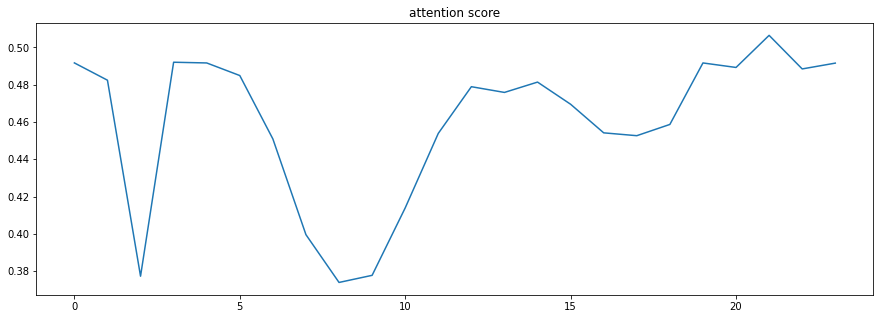

In [40]:
i=4
attention_score_block1_res = keras.Model(inputs=model_res.input,
                                         outputs=model_res.get_layer('attention_scoreblock1_res').output)
attention_score1_res = attention_score_block1_res(training_set[i:i+1])
plt.figure(figsize=(15,5))
plt.plot(attention_score1_res[0,:])
plt.title('attention score')

# Res

In [41]:
encoded_att_res = keras.Model(inputs=model_res.input,
                              outputs=model_res.get_layer('encoded_res').output)

encoded_attres = []
for k in range(test_set.shape[0]//10):
    encoded_attres.append(encoded_att_res(test_set[k*10:k*10+10]).numpy())
encoded_attres = np.concatenate(encoded_attres,axis = 0)

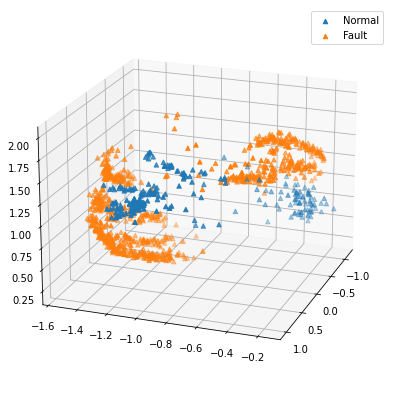

In [232]:
normal_index = test_label[:encoded_0.shape[0]]==0
fault_index1 = test_label[:encoded_0.shape[0]]==1
n_plot = 1000

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    encoded_attres[normal_index,0],
    encoded_attres[normal_index,1],
    encoded_attres[normal_index,2],
    marker='^'
)
ax.scatter(
    encoded_attres[0:n_plot][fault_index1[0:n_plot],0],
    encoded_attres[0:n_plot][fault_index1[0:n_plot],1],
    encoded_attres[0:n_plot][fault_index1[0:n_plot],2],
    marker='^'
)


plt.legend(['Normal','Fault'])
ax.azim = 20
ax.elev = 20

# Classification

In [162]:
encoded_att_res = keras.Model(inputs=model_res.input,
                              outputs=model_res.get_layer('encoded_res').output)

latent_res = []
for k in range(Dataset.shape[0]//10):
    latent_res.append(encoded_att_res(Dataset[k*10:k*10+10]).numpy())
latent_res = np.concatenate(latent_res,axis = 0)

In [234]:
encoded_att_pcp = keras.Model(inputs=model.input,
                              outputs=model.get_layer('encoded').output)

latent_pcp = []
for k in range(Dataset.shape[0]//10):
    latent_pcp.append(encoded_att_pcp(Dataset[k*10:k*10+10]).numpy())
latent_pcp = np.concatenate(latent_pcp,axis = 0)

In [223]:
latents = latent_res
n__=latents.shape[0]
label_ = label[:n__]

shuffle_id = np.random.permutation(np.arange(n__))
latents = latents[shuffle_id]
label_ = label_[shuffle_id]

## KDE

In [34]:
from sklearn.neighbors import KernelDensity

In [331]:
#latents = latent_pcp #4e-2

n_train = 20#int(n__*0.5)
print(n_train)
normal_index = label_==0
anomaly_index = label_==1

kde_3d_normal = KernelDensity(bandwidth=1e-2, kernel='gaussian', algorithm='ball_tree')
kde_3d_normal.fit(latents[:n_train][normal_index[:n_train],:])
kde_3d_anomaly = KernelDensity(bandwidth=1e-2, kernel='gaussian', algorithm='ball_tree')
kde_3d_anomaly.fit(latents[:n_train][anomaly_index[:n_train],:])


pdf0_train_normal = kde_3d_normal.score_samples(latents[:n_train][normal_index[:n_train],:])
pdf0_train_fault = kde_3d_normal.score_samples(latents[:n_train][anomaly_index[:n_train],:])
pdf1_train_normal = kde_3d_anomaly.score_samples(latents[:n_train][normal_index[:n_train],:])
pdf1_train_fault = kde_3d_anomaly.score_samples(latents[:n_train][anomaly_index[:n_train],:])



pdf0_test_normal = kde_3d_normal.score_samples(latents[n_train:][normal_index[n_train:],:])
pdf0_test_fault = kde_3d_normal.score_samples(latents[n_train:][anomaly_index[n_train:],:])
pdf1_test_normal = kde_3d_anomaly.score_samples(latents[n_train:][normal_index[n_train:],:])
pdf1_test_fault = kde_3d_anomaly.score_samples(latents[n_train:][anomaly_index[n_train:],:])


20


(0.0, 250.0, -30.0, 20.0)

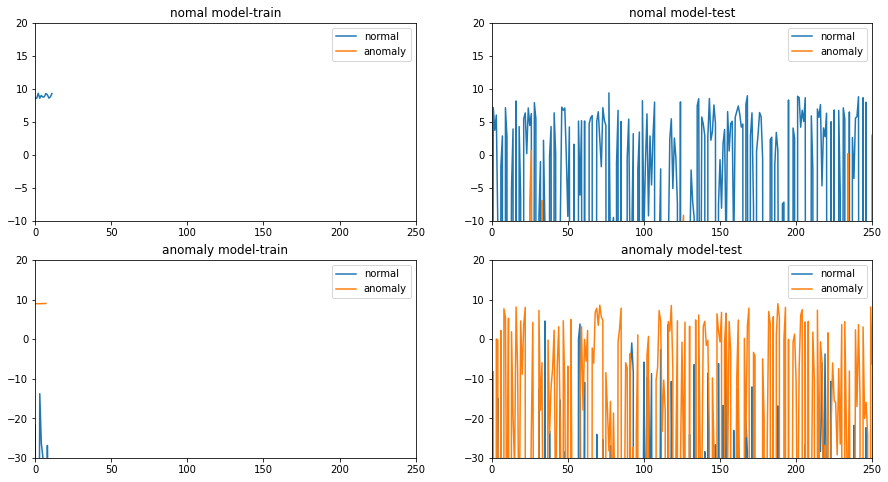

In [332]:
plt.figure(figsize=(15,8))

plt.subplot(2,2,1)
plt.plot(pdf0_train_normal)
plt.plot(pdf0_train_fault)
plt.legend(['normal','anomaly'])
plt.title('nomal model-train')
plt.axis([0,250,-10,20])


plt.subplot(2,2,2)
plt.plot(pdf0_test_normal)
plt.plot(pdf0_test_fault)
plt.legend(['normal','anomaly'])
plt.title('nomal model-test')
plt.axis([0,250,-10,20])

plt.subplot(2,2,3)
plt.plot(pdf1_train_normal)
plt.plot(pdf1_train_fault)
plt.legend(['normal','anomaly'])
plt.title('anomaly model-train')
plt.axis([0,250,-30,20])


plt.subplot(2,2,4)
plt.plot(pdf1_test_normal)
plt.plot(pdf1_test_fault)
plt.legend(['normal','anomaly'])
plt.title('anomaly model-test')
plt.axis([0,250,-30,20])

In [333]:
positive_score = kde_3d_normal.score_samples(latents[n_train:])
negative_score = kde_3d_anomaly.score_samples(latents[n_train:])
decision = 0.5-np.sign(positive_score-negative_score)*0.5


In [334]:
fault_det = decision[label_[n_train:n__]==1]
print(fault_det[fault_det==1].shape[0],
      label_[n_train:n__][label_[n_train:n__]==1].shape[0],
      fault_det[fault_det==1].shape[0]/label_[n_train:][label_[n_train:]==1].shape[0])

506 537 0.9422718808193669


In [335]:
print(label_[n_train:n__].shape[0]-np.sum(np.abs(decision-label_[n_train:n__])),
      label_[n_train:n__].shape[0],
      1-np.sum(np.abs(decision-label_[n_train:n__]))/label_[n_train:n__].shape[0])

935.0 1070 0.8738317757009346


# KDE Anomaly

In [338]:
#test

n_train = int(n__*0.1)
print(n_train)
normal_index = label_==0
anomaly_index = label_==1

kde_3d_normal = KernelDensity(bandwidth=2e-2, kernel='gaussian', algorithm='ball_tree')#2e-2
kde_3d_normal.fit(latents[:n_train][normal_index[:n_train],:])

pdf0_train_normal = kde_3d_normal.score_samples(latents[:n_train][normal_index[:n_train],:])
pdf0_train_fault = kde_3d_normal.score_samples(latents[:n_train][anomaly_index[:n_train],:])

pdf0_test_normal = kde_3d_normal.score_samples(latents[n_train:][normal_index[n_train:],:])
pdf0_test_fault = kde_3d_normal.score_samples(latents[n_train:][anomaly_index[n_train:],:])

positive_score = kde_3d_normal.score_samples(latents[n_train:])
negative_score = -1*np.ones(len(positive_score))
decision = 0.5-np.sign(positive_score-negative_score)*0.5

fault_det = decision[label_[n_train:n__]==1]
print(fault_det[fault_det==1].shape[0],
      label_[n_train:n__][label_[n_train:n__]==1].shape[0],
      fault_det[fault_det==1].shape[0]/label_[n_train:][label_[n_train:]==1].shape[0])

print(label_[n_train:n__].shape[0]-np.sum(np.abs(decision-label_[n_train:n__])),
      label_[n_train:n__].shape[0],
      1-np.sum(np.abs(decision-label_[n_train:n__]))/label_[n_train:n__].shape[0])

109
445 497 0.8953722334004024
857.0 981 0.873598369011213


In [242]:
latents = latent_res
n__=latents.shape[0]
label_ = label[:n__]

shuffle_id = np.random.permutation(np.arange(n__))
latents = latents[shuffle_id]
label_ = label_[shuffle_id]

In [257]:
recal_=[]
accu_=[]

##Wafer
#number_=[15,35,71,143,358,716,3580] 
#thres = [800,500,300,100,100,70,29]

#IPD
number_=[10,21,54,109,219,548]
thres = [9,9,6,4,3,2]


for i in range(len(number_)):
#test
    n_train = number_[i]
    
    normal_index = label_==0
    anomaly_index = label_==1

    kde_3d_normal = KernelDensity(bandwidth=2e-2, kernel='gaussian', algorithm='ball_tree')
    kde_3d_normal.fit(latents[:n_train][normal_index[:n_train],:])

    pdf0_train_normal = kde_3d_normal.score_samples(latents[:n_train][normal_index[:n_train],:])
    pdf0_train_fault = kde_3d_normal.score_samples(latents[:n_train][anomaly_index[:n_train],:])

    pdf0_test_normal = kde_3d_normal.score_samples(latents[n_train:][normal_index[n_train:],:])
    pdf0_test_fault = kde_3d_normal.score_samples(latents[n_train:][anomaly_index[n_train:],:])

    positive_score = kde_3d_normal.score_samples(latents[n_train:])
    negative_score = -thres[i]*np.ones(len(positive_score))
    decision = 0.5-np.sign(positive_score-negative_score)*0.5

    fault_det = decision[label_[n_train:n__]==1]
    recal_.append(fault_det[fault_det==1].shape[0]/label_[n_train:][label_[n_train:]==1].shape[0])
    accu_.append(1-np.sum(np.abs(decision-label_[n_train:n__]))/label_[n_train:n__].shape[0])

Text(0.5, 0, 'label number')

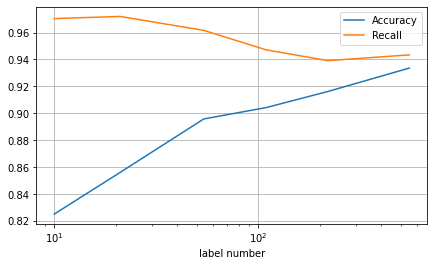

In [258]:
plt.figure(figsize=(7,4))
plt.plot(number_,accu_,label='Accuracy')
plt.plot(number_,recal_,label='Recall')
plt.legend(['Accuracy','Recall'])
plt.semilogx()
#plt.ylim(0.4,1)
plt.grid()
plt.xlabel('label number')

In [305]:
print(number_)
print(accu_)
print(recal_)

[10, 21, 54, 109, 219, 548]
[0.825, 0.8559401309635173, 0.8957528957528957, 0.9041794087665648, 0.9161882893226176, 0.933579335793358]
[0.9703703703703703, 0.9719626168224299, 0.9616122840690979, 0.9471544715447154, 0.9391100702576113, 0.9433962264150944]


In [ ]:
Cons['ItalyPowerDemand']['Proposed']=np.array([accu_,recal_])

In [36]:
Cons={} #'Wafer','ItalyPowerDemand'
Cons['Wafer']={}
Cons['ItalyPowerDemand']={}

In [37]:
acc_tmp=np.array([0.825, 0.8559401309635173, 0.8957528957528957, 0.9041794087665648, 0.9161882893226176, 0.933579335793358])
recall_tmp=np.array([0.9703703703703703, 0.9719626168224299, 0.9616122840690979, 0.9471544715447154, 0.9391100702576113, 0.9433962264150944])

In [38]:
Cons['ItalyPowerDemand']['Proposed']=np.array([acc_tmp,recall_tmp])

In [39]:
acc_tmp=np.array([0.8255241822756499,0.9031420956655912,0.9125898773438601,0.9212647770972795,0.9360417278871582,0.9325062034739455,0.9433872767857142])
recall_tmp=np.array([0.9309711286089237,0.9439632545931758,0.9728346456692913,0.9795275590551181,0.9791338582677167,0.9607611548556431,0.9876640419947507])

In [40]:
Cons['Wafer']['SPE']=np.array([acc_tmp,recall_tmp])

In [41]:
acc_tmp=np.array([0.8665082471344703,0.9015289661944171,0.9034259128718455,0.8373451075345393,0.9093446958565972,0.901985111662531,0.916247906197655])
recall_tmp=np.array([0.13648293963254593,0.3215223097112861,0.847769028871391,0.9225721784776902,0.9225721784776902,0.9186351706036745,0.931758530183727])

In [42]:
Cons['Wafer']['LAKE']=np.array([acc_tmp,recall_tmp])

In [43]:
acc_tmp=np.array([0.5922560805143975,0.677794922148969,0.795009163964472,0.8109955846745478,0.7225977079047899,0.8636786600496278,0.9545200892857143])
recall_tmp=np.array([0.9566929133858267,0.979002624671916,0.9803149606299213,0.9724409448818898,0.9803149606299213, 0.9881889763779528,0.9960629921259843])

In [44]:
Cons['Wafer']['RM']=np.array([acc_tmp,recall_tmp])

In [45]:
acc_tmp=np.array([0.7360957642725598,0.7874418604651163,0.8290786948176583,0.8261398176291793,0.8574686431014824,0.9270134228187918])
recall_tmp=np.array([0.8054844606946983,0.8585009140767825,0.9155393053016455,0.9058500914076782,0.9261425959780623,0.9466179159049359])

In [46]:
Cons['ItalyPowerDemand']['SPE']=np.array([acc_tmp,recall_tmp])

In [47]:
acc_tmp=np.array([0.6335174953959485,0.7992633517495396,0.8027906976744186,0.8435700575815739,0.8247213779128673,0.9981751824817519])
recall_tmp=np.array([0.6928702010968921,0.8537477148080439,0.8738574040219378,0.8848263254113345,0.8903107861060329,0.999])

In [48]:
Cons['ItalyPowerDemand']['LAKE']=np.array([acc_tmp,recall_tmp])

In [49]:
acc_tmp=np.array([0.8057090239410681,0.8,0.8205374280230326,0.8470111448834853,0.8437856328392246,0.9446308724832215])
recall_tmp=np.array([0.926873857404022,0.9634369287020109,0.9506398537477148,0.9287020109689214,0.9451553930530164, 0.9707495429616088])

In [50]:
Cons['ItalyPowerDemand']['RM']=np.array([acc_tmp,recall_tmp])

In [51]:
acc_tmp=np.array([0.9564730580825752, 0.9612631578947368, 0.958104104951333, 0.9571041755736069, 0.9667744780946781, 0.9702048417132216, 0.95])
recall_tmp=np.array([0.9963978073610024, 0.9963876236846239, 0.9970017358371469, 0.9980870396939263, 0.9980263157894737, 0.993060374739764, 0.9576376004947433])

In [52]:
Cons['Wafer']['Proposed']=np.array([acc_tmp,recall_tmp])

In [53]:
np.save('Consequence.npy', Cons)

In [31]:
#plt.plot(number_,accu_,label='Accuracy')
#plt.plot(number_,recal_,label='Recall')
#
#plt.semilogx()
##plt.ylim(0.4,1)
#plt.grid()
#plt.xlabel('label number')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier 

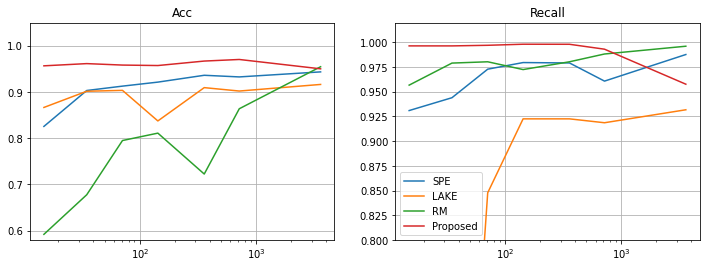

In [27]:
plt.figure(figsize=(12,4))
number_=[15,35,71,143,358,716,3580] 
plt.subplot(1,2,1)
plt.ylim(0.58,1.05)
plt.title('Acc')
plt.semilogx()
plt.grid()
plt.subplot(1,2,2)
plt.ylim(0.8,1.02)
plt.title('Recall')
plt.semilogx()
plt.grid()
for key in Cons['Wafer'].keys():
    plt.subplot(1,2,1)
    plt.plot(number_,Cons['Wafer'][key][0,:],label=key)
    plt.subplot(1,2,2)
    plt.plot(number_,Cons['Wafer'][key][1,:],label=key)
plt.legend()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier 

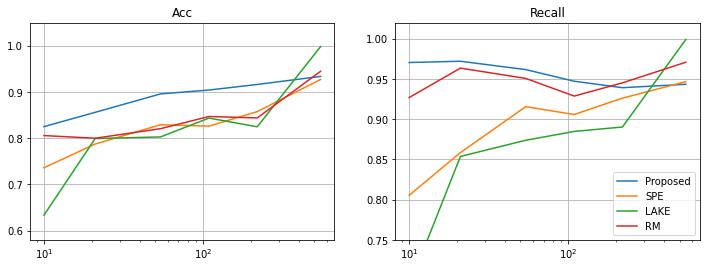

In [54]:
plt.figure(figsize=(12,4))
number_=[10,21,54,109,219,548]
plt.subplot(1,2,1)
plt.ylim(0.58,1.05)
plt.title('Acc')
plt.semilogx()
plt.grid()
plt.subplot(1,2,2)
plt.ylim(0.75,1.02)
plt.title('Recall')
plt.semilogx()
plt.grid()
for key in Cons['ItalyPowerDemand'].keys():
    plt.subplot(1,2,1)
    plt.plot(number_,Cons['ItalyPowerDemand'][key][0,:],label=key)
    plt.subplot(1,2,2)
    plt.plot(number_,Cons['ItalyPowerDemand'][key][1,:],label=key)
plt.legend()

## Softmax fine-tuning

In [233]:
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [324]:
n_train = 548#int(training_set.shape[0]*0.0)
print(n_train)
training_set_labeled = Dataset[:n_train]
test_set_unlabeled = Dataset[n_train:]

enc = preprocessing.OneHotEncoder(categories='auto')
enc.fit(label.reshape(-1, 1))
train_label_oh = enc.transform(label[:n_train].reshape(-1, 1)).toarray()
test_label_oh = enc.transform(label[n_train:].reshape(-1, 1)).toarray()

548


In [283]:
model_res.trainable = False

inputs_tuning = model_res.input
encoded_out = model_res.get_layer('encoded_res').output
classifier_out = layers.Dense(2,activation='softmax')(encoded_out)
model_f = keras.Model(inputs=inputs_tuning,
                      outputs=classifier_out)

In [ ]:
model_res.trainable = True #True #False

In [329]:
model_f.compile(loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(), metrics=['accuracy'])  # 1e-5

In [330]:
model_f.fit(
    training_set_labeled,
    train_label_oh,
    epochs=50,
    batch_size=32
)

Epoch 1/50
18/18 [==============================] - 10s 51ms/step - loss: 0.0676 - accuracy: 0.9851
Epoch 2/50
18/18 [==============================] - 1s 47ms/step - loss: 0.0711 - accuracy: 0.9800
Epoch 3/50
18/18 [==============================] - 1s 47ms/step - loss: 0.0449 - accuracy: 0.9891
Epoch 4/50
18/18 [==============================] - 1s 46ms/step - loss: 0.0655 - accuracy: 0.9793
Epoch 5/50
18/18 [==============================] - 1s 47ms/step - loss: 0.0480 - accuracy: 0.9850
Epoch 6/50
18/18 [==============================] - 1s 48ms/step - loss: 0.0475 - accuracy: 0.9828
Epoch 7/50
18/18 [==============================] - 1s 47ms/step - loss: 0.0404 - accuracy: 0.9901
Epoch 8/50
18/18 [==============================] - 1s 49ms/step - loss: 0.0322 - accuracy: 0.9924
Epoch 9/50
18/18 [==============================] - 1s 47ms/step - loss: 0.0308 - accuracy: 0.9931
Epoch 10/50
18/18 [==============================] - 1s 49ms/step - loss: 0.0351 - accuracy: 0.9932
Epoch 11

In [331]:
test_pred = model_f.predict(test_set_unlabeled)
test_pred = np.argmax(test_pred , axis=1)

print('accuracy:',accuracy_score(test_pred,label[n_train:]))
print('recall:',recall_score(1-test_pred,1-label[n_train:]))

accuracy: 0.9525547445255474
recall: 0.9885931558935361
